# Dealing with multiple feeds


In some cases the fed-batch process uses multiple feeding mediums. This is typically the case in cultivation of mammalians cells. This tutorial will show how to use the pseudo batch transformation to handle multiple feeding mediums and how calculate rates and yields from measurements. We will, again, use simulated data to showcase the workflow. This fed-batch process seeks to mimic a cultivation of mammalians cells. These simulated cells require two substrates to grow; glucose and glutamate. The bioreactor is fed with two different feed mediums, one containing concentrated glucose and one complex medium that contain glucose, and glutamate. The feeding is also not done through a "continuous" exponential feed, but instead as pulse feed, i.e. at certain time points a given volume of each feed is added to the bioreactor.

In the simulation the cells are fed once every 24 hours and further a sample is withdrawn every 12 hours.

## loading fedbatch data

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform_pandas, pseudobatch_transform
from pseudobatch.datasets import load_cho_cell_like_fedbatch

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
fedbatch_df_measurement = load_cho_cell_like_fedbatch(sampling_points_only=True)

# for visualization purposes we will also load the full dataset
fedbatch_df = load_cho_cell_like_fedbatch(sampling_points_only=False)

First, let's quickly inspect the dataframe

In [6]:
(fedbatch_df_measurement
    .filter(['timestamp', 'sample_volume', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum1', 'v_Feed_accum2'])
    .head()
)

,timestamp,sample_volume,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum1,v_Feed_accum2
0,10.0,100.0,1.644817,47.882089,0.940479,1000.0,0.0,0.0
1,16.0,100.0,3.310148,44.801226,2.308565,900.0,0.0,0.0
2,22.0,100.0,6.501640,38.896967,4.930408,800.0,0.0,0.0
3,28.0,100.0,10.882236,36.572833,8.582690,805.0,100.0,5.0
4,34.0,100.0,19.715418,20.231446,15.839239,705.0,100.0,5.0


This dataframe is structured very similar to the one used in the previous tutorial. This time the fed-batch process utilised two feed streams and therefore there are two accumulated feed columns. We can go straight to the pseudo batch transformation.

In this simulation feed 1 contained only glucose, while feed 2 contain both glucose and glutamate. We will store the concentrations in variable here.

In [7]:
glucose_in_feed1 = fedbatch_df.c_Glucose_feed1.iloc[0] 
glucose_in_feed2 = 0  
glutamate_in_feed1 = fedbatch_df.c_Glutamate_feed1.iloc[0]
glutamate_in_feed2 = fedbatch_df.c_Glutamate_feed2.iloc[0]

## Applying the pseudo batch transformation
We can now apply the pseudo batch transformation to the data. Notice that to include both feeds we simply supply a list of the columns names in the `accumulated_feed_colnam` argument. The `concentrations_in_feed` is specified as follows: The outer list iterates over the measured concentrations (in this case Biomass, Glucose, Product, CO2, Glutamate), while the inner list iterates over the feeding mediums. **Important:** the order HAS to be the same for `concetration_in_feed` and both `measured_concentration_colnames` and `accumulated_feed_colname`!

In [8]:
fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo", "c_Glutamate_pseudo"]] = pseudobatch_transform_pandas(
    df=fedbatch_df_measurement,
    measured_concentration_colnames=['c_Biomass', 'c_Glucose', 'c_Product', 'c_CO2', 'c_Glutamate'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname=['v_Feed_accum1', 'v_Feed_accum2'],
    concentration_in_feed=[[0, 0], [glucose_in_feed1, glucose_in_feed2], [0, 0], [0, 0], [glutamate_in_feed1, glutamate_in_feed2]],
    sample_volume_colname='sample_volume'
)

We can take a quick look at what the pseudo batch transformed data looks like by plotting it against time.

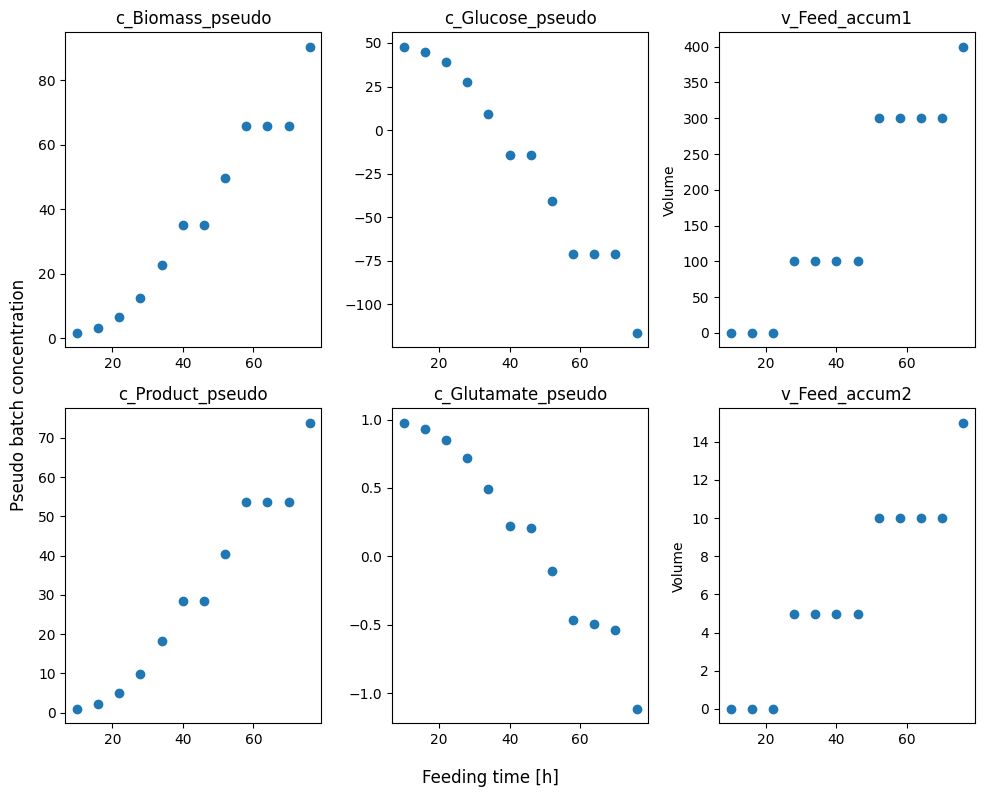

In [19]:
plot_cols = ['c_Biomass_pseudo', 'c_Glucose_pseudo','v_Feed_accum1','c_Product_pseudo',  'c_Glutamate_pseudo', 'v_Feed_accum2']
fig, axes = plt.subplots(nrows=2, ncols=len(plot_cols)//2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), plot_cols):
    ax.scatter(fedbatch_df_measurement.timestamp, fedbatch_df_measurement[col])
    ax.set_title(col)

    if col.startswith('v_'):
        ax.set_ylabel('Volume')

fig.supxlabel('Feeding time [h]')
fig.supylabel('Pseudo batch concentration')
fig.tight_layout()

We see that the growth occasionally stops completely, we hypothesis that this is because the real concentration of one of the substrates reaches zero. Notice that we can see this in the pseudo batch transformed data. Therefor, we will inspect the actual measured concentrations of substrates.

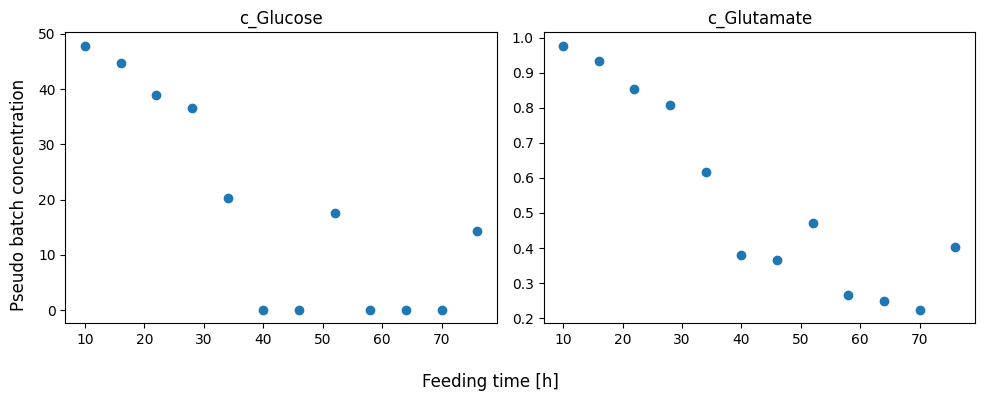

In [21]:
plot_cols = ['c_Glucose', 'c_Glutamate']
fig, axes = plt.subplots(nrows=1, ncols=len(plot_cols), figsize=(10, 4))
for ax, col in zip(axes.flatten(), plot_cols):
    ax.scatter(fedbatch_df_measurement.timestamp, fedbatch_df_measurement[col])
    ax.set_title(col)

fig.supxlabel('Feeding time [h]')
fig.supylabel('Pseudo batch concentration')
fig.tight_layout()

Indeed we see that at around hour 40 - 45 and 58 - 70, the concentration of glucose was zero, which completely stopped growth. Thus, it is important to inspect both the actual measurements and the pseudo batch transformed data.

From pseudo batch data one can estimate overall or time dependent yield using the methods from the previous tutorials.